# Introduction

This notebook uses data from the [OpenPV project](https://openpv.nrel.gov/) and the US Census to make predictions about what economic and demographic characteristics lead to installation of solar panels. The data used here was collected via the National Renewable Energy Laboratory and Census APIs and was preprocessed before use.

The data is first loaded in, and descriptive statistics are calculated.

In [2]:
# Import needed modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [67]:
%matplotlib inline
# Create OS independent file name

subdir = os.path.join(os.path.curdir, "data")

file_path = os.path.join(subdir, "combined_data.csv")

# Read file
solar_data = pd.read_csv(file_path)

# Calculate demographic characteristics

solar_data['Percent White'] = solar_data['White Population'] / solar_data['Population']
solar_data['Percent Bachelors'] = solar_data['Bachelors Degree'] / solar_data['Population']

count    6.720000e+02
mean     2.252654e+04
std      8.655103e+04
min      3.800000e-01
25%      4.709650e+01
50%      4.493700e+02
75%      5.272334e+03
max      1.151215e+06
Name: capacity, dtype: float64


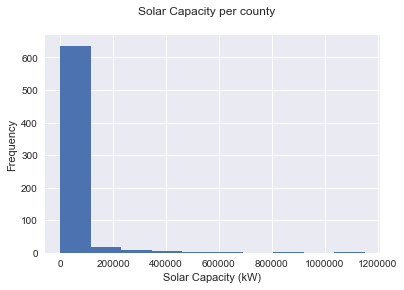

In [68]:
%matplotlib inline
# Check distribution of capacity
print(solar_data['capacity'].describe())

fig, ax = plt.subplots(1)

fig.suptitle("Solar Capacity per county")

solar_data['capacity'].plot(kind='hist', ax = ax)

ax.set_xlabel('Solar Capacity (kW)')

plt.show()

The distribution of solar capacity per county is very highly right skewed, with many counties not having much capacity with a few extreme outliers. To remove this skew, we perform a log transform on the data so that we can perform regression.

count    672.000000
mean       6.250897
std        3.122404
min       -0.967584
25%        3.852168
50%        6.107847
75%        8.570227
max       13.956328
Name: log capacity, dtype: float64


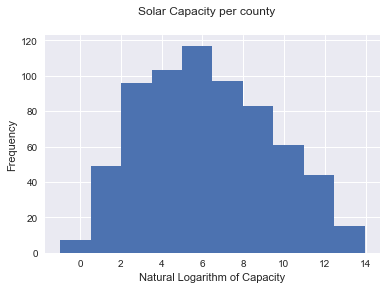

In [69]:
%matplotlib inline
# Remove skew

solar_data['log capacity'] = np.log(solar_data['capacity'].values)

# Plot and describe log transform of data

print(solar_data['log capacity'].describe())

fig, ax = plt.subplots(1)

fig.suptitle("Solar Capacity per county")

solar_data['log capacity'].plot(kind='hist', ax = ax)

ax.set_xlabel('Natural Logarithm of Capacity')

plt.show()

Here, the distribution is much better described by a normal distribution. Indeed, the mean and median are now much closer (6.25 and 6.10, respectively.) We now want to select predictors for our model and check their distributions. By using a log transform, we are essentially going to be performing Poisson regression. 

In [70]:
# Filter data for desired variables

solar_data_filtered = solar_data.filter(['combined', 'log capacity', 'cost', 'per_gop',
                                        'Median Age', 'Percent White', 'Percent Bachelors', 
                                        'Median Household Income', 'Median House Price'])

solar_data_filtered = solar_data_filtered.rename(columns={'cost' : 'Cost per kW', 'per_gop' : 'GOP Vote Share'})


solar_data_filtered = solar_data_filtered.loc[solar_data['Percent Bachelors'].isnull() == False, :]

In [71]:
solar_data_filtered.describe()


,log capacity,Cost per kW,GOP Vote Share,Median Age,Percent White,Percent Bachelors,Median Household Income,Median House Price
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000
mean,6.258222,6.674659,0.512878,38.789238,0.794443,0.122164,56922.724963,205775.037369
std,3.126361,1.892648,0.150584,4.734550,0.145790,0.040475,14832.944155,118147.201352
min,-0.967584,2.866667,0.041221,24.500000,0.164846,0.030531,28212.000000,55000.000000
25%,3.856722,5.575667,0.421453,35.900000,0.725905,0.091786,46649.000000,134100.000000
50%,6.107913,6.421993,0.527331,38.500000,0.832569,0.118862,53548.000000,168500.000000
75%,8.572671,7.511776,0.624815,41.500000,0.901477,0.146070,63180.000000,238500.000000
max,13.956328,24.120000,0.878105,66.500000,0.979318,0.262558,125003.000000,941400.000000


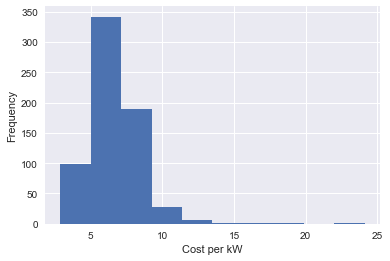

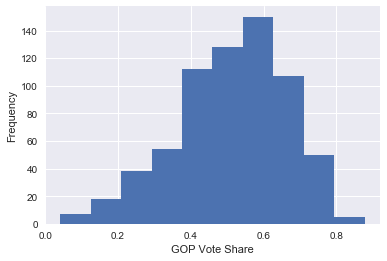

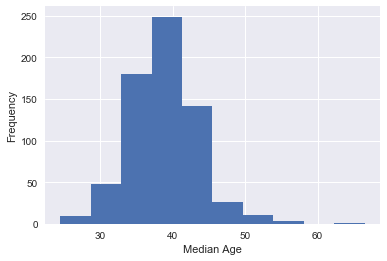

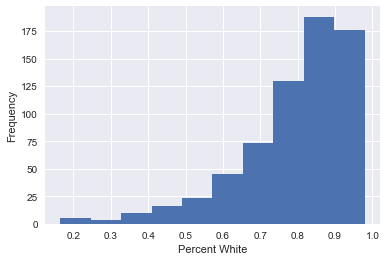

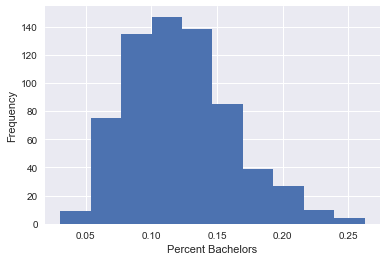

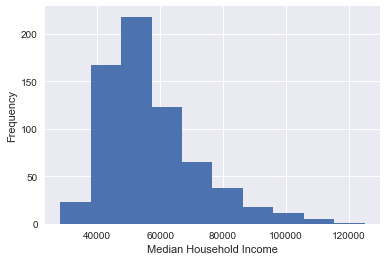

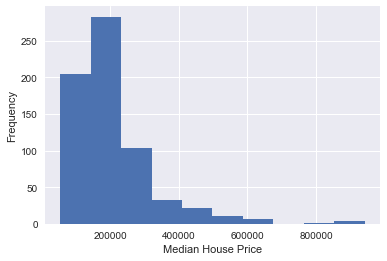

In [73]:
%matplotlib inline

columns = ['Cost per kW', 'GOP Vote Share', 'Median Age', 'Percent White', 
           'Percent Bachelors', 'Median Household Income', 'Median House Price']

for column in columns:
    fig, ax = plt.subplots(1)
    solar_data_filtered[column].plot(kind='hist', ax = ax)
    ax.set_xlabel(column)
    plt.show()

In [74]:
reg_data = solar_data_filtered

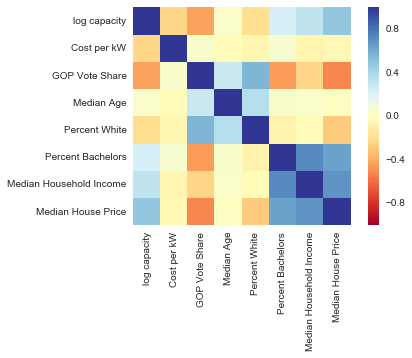

In [75]:
%matplotlib inline

sns.heatmap(reg_data.corr(), square=True, cmap='RdYlBu')

The GOP vote share in the 2016 Presidential Election, Median Age, Percentage of White People, Median Household income, and Median House Price are used as variables to predict solar capacity per capita. The heatmap above shows that each of the variables are highly intercorrelated with each other. 

## Machine learning with regression

We use the variables with machine learning in scikit-learn to find what predicts solar capacity. Since some of the variables are intercorrelated, we use regularized regression. 

In [76]:
from sklearn import model_selection
from sklearn import linear_model


# Split data into dependent and independent variables.
y = reg_data["log capacity"].values
X = reg_data.drop(["log capacity", "combined"], axis = 1).values

# Pick l1 ratio hyperparameter space

l1_space = np.linspace(0.00001, 1, 60)

# Setup cross validation and parameter search
elastic = linear_model.ElasticNetCV(l1_ratio = l1_space,
                                    normalize = True, cv = 10)

# Create train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 21)

# Fit to the training set

elastic.fit(X_train, y_train)

# Check linear regression R^2

r2 = elastic.score(X_test, y_test)

print("Tuned ElasticNet Alpha {}".format(elastic.alpha_))
print("Tuned ElasticNet l1 ratio {}".format(elastic.l1_ratio_))
print("Tuned R squared {}".format(r2))



Tuned ElasticNet Alpha 0.0004829634541746483
Tuned ElasticNet l1 ratio 0.7627142372881356
Tuned R squared 0.26757537754900773


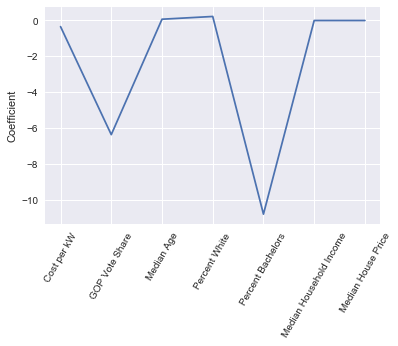

In [77]:
%matplotlib inline

elastic_coef = elastic.coef_

predictors = reg_data.drop(["log capacity", "combined"], axis = 1).columns

plt.plot(range(len(predictors)), elastic_coef)
plt.xticks(range(len(predictors)), predictors.values, rotation = 60)
plt.ylabel("Coefficient")

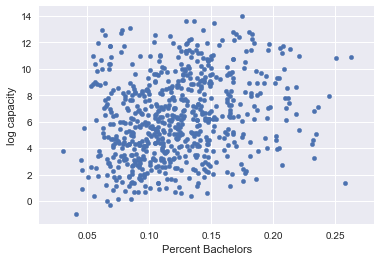

In [78]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data_filtered.plot.scatter(x = 'Percent Bachelors', y = 'log capacity', ax = ax)

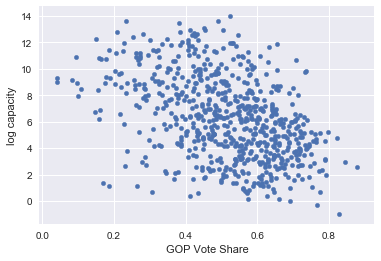

In [84]:
%matplotlib inline
fig, ax = plt.subplots(1)

reg_data.plot.scatter(x = 'GOP Vote Share', y = 'log capacity', ax = ax)

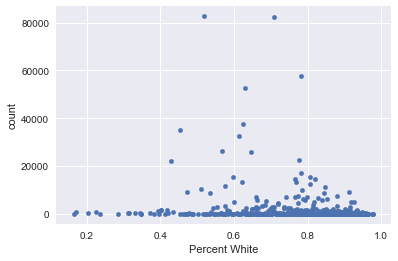

In [57]:
%matplotlib inline
fig, ax = plt.subplots(1)

solar_data_filtered.plot.scatter(x = 'Percent White', y = 'count', ax = ax)